In [1]:
import pandas as pd
import scipy.odr as odr
import seaborn as sns
import numpy as np

import altair as alt
from power_laws import *

In [2]:
# Load the data from the Pantheria DB
pantheria_df = pd.read_csv('../data/PanTHERIA_1-0_WR05_Aug2008.txt', sep='\t', na_values=[-999])
pantheria_df.shape

(5416, 55)

In [3]:
mask = np.logical_and(pantheria_df['5-1_AdultBodyMass_g'].notnull(),
                      pantheria_df['18-1_BasalMetRate_mLO2hr'].notnull())
sub_df = pantheria_df[mask].copy()
print(sub_df.shape)

# Note: power-law fitting code subtly assumes log base e by exponentiating the fit intercept
xs, ys = sub_df['5-1_AdultBodyMass_g'], sub_df['18-1_BasalMetRate_mLO2hr']
log_xs, log_ys = np.log(xs), np.log(ys)
exp, pre, r = fit_power_law_odr(log_xs, log_ys)
print('y ≈ {0:.2f} x^{1:.2f}, R = {2:.3f}'.format(pre, exp, r))

residuals = (log_ys - (pre + exp*log_xs))
sub_df['residual'] = residuals
sub_df['abs_residual'] = np.abs(residuals)

exponents, prefactors, rs = bootstrap_power_law_odr(xs, ys, rounds=10000)

fit_df = pd.DataFrame(dict(exponent=exponents, prefactor=prefactors, R=rs))

(573, 55)
y ≈ 3.52 x^0.72, R = 0.961


In [4]:
sub_df.sort_values('abs_residual', ascending=False).head(10)

,MSW05_Order,MSW05_Family,MSW05_Genus,MSW05_Species,MSW05_Binomial,1-1_ActivityCycle,5-1_AdultBodyMass_g,8-1_AdultForearmLen_mm,13-1_AdultHeadBodyLen_mm,2-1_AgeatEyeOpening_d,...,27-1_HuPopDen_Min_n/km2,27-2_HuPopDen_Mean_n/km2,27-3_HuPopDen_5p_n/km2,27-4_HuPopDen_Change,28-1_Precip_Mean_mm,28-2_Temp_Mean_01degC,30-1_AET_Mean_mm,30-2_PET_Mean_mm,residual,abs_residual
2104,Carnivora,Felidae,Leptailurus,serval,Leptailurus serval,2.0,11999.96,NaN,832.51,9.03,...,0.0,36.32,1.0,0.13,89.07,235.57,909.16,1534.53,-4.737077,4.737077
4710,Diprotodontia,Acrobatidae,Acrobates,pygmaeus,Acrobates pygmaeus,NaN,13.84,NaN,NaN,65.00,...,0.0,12.18,0.0,0.04,61.57,185.70,673.13,1288.68,4.201285,4.201285
4778,Monotremata,Tachyglossidae,Tachyglossus,aculeatus,Tachyglossus aculeatus,2.0,4499.97,NaN,375.00,NaN,...,0.0,3.53,0.0,0.04,44.83,209.86,476.82,1350.04,-3.556799,3.556799
4664,Sirenia,Trichechidae,Trichechus,inunguis,Trichechus inunguis,2.0,418001.19,NaN,2751.93,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.495632,3.495632
5240,Cingulata,Dasypodidae,Tolypeutes,matacus,Tolypeutes matacus,2.0,1303.47,NaN,NaN,NaN,...,0.0,7.08,0.0,0.12,86.56,213.39,985.55,1294.48,-3.342083,3.342083
491,Rodentia,Muridae,Dipodillus,dasyurus,Dipodillus dasyurus,NaN,27.50,NaN,83.05,NaN,...,0.0,34.39,1.0,0.15,8.78,222.72,162.44,1263.69,-3.305940,3.305940
753,Rodentia,Capromyidae,Capromys,pilorides,Capromys pilorides,NaN,5200.00,NaN,NaN,NaN,...,2.0,104.74,16.0,0.02,103.29,252.28,1271.00,1782.03,-3.281995,3.281995
871,Pilosa,Megalonychidae,Choloepus,hoffmanni,Choloepus hoffmanni,2.0,5893.50,NaN,NaN,0.00,...,0.0,40.18,1.0,0.13,192.46,237.35,1422.76,1574.86,-3.229516,3.229516
3848,Cingulata,Dasypodidae,Priodontes,maximus,Priodontes maximus,1.0,40641.89,NaN,874.99,NaN,...,0.0,9.21,0.0,0.12,156.50,242.69,1332.92,1513.92,-3.154653,3.154653
598,Rodentia,Muridae,Gerbillus,gerbillus,Gerbillus gerbillus,NaN,26.99,NaN,NaN,NaN,...,0.0,23.26,0.0,0.10,17.95,233.50,237.04,1347.34,-3.149386,3.149386


In [5]:
median_fit = fit_df.median()
fit_df.quantile(q=[0.01,0.1,0.25,0.5,0.75,0.9,0.99])

,exponent,prefactor,R
0.01,0.697683,3.082328,0.927066
0.10,0.708272,3.274021,0.944860
0.25,0.714394,3.388039,0.954332
0.50,0.721419,3.513418,0.961767
0.75,0.728159,3.645271,0.970329
0.90,0.734528,3.769477,0.973521
0.99,0.745577,3.996278,0.977141


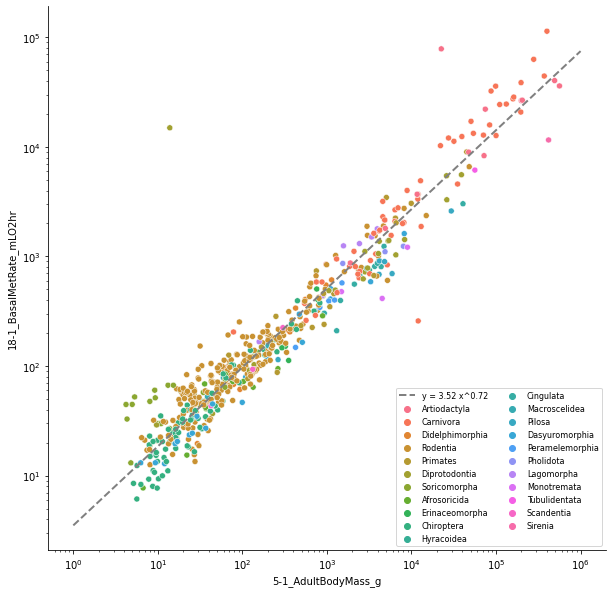

In [6]:
plt.figure(figsize=(10,10))
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(data=sub_df, x='5-1_AdultBodyMass_g', y='18-1_BasalMetRate_mLO2hr',
                hue='MSW05_Order')

xs = np.logspace(0, 6, 100)
ys_pred = np.power(xs, exp)*pre
plt.plot(xs, ys_pred, label='y = {0:.2f} x^{1:.2f}'.format(pre, exp),
         color='grey', ls='--', lw=2)

plt.legend(ncol=2, fontsize=8, loc=4)
sns.despine()
plt.savefig('../figures/pantheria_metabolic_rate_scaling_fit.png', dpi=600, facecolor='w')
plt.show()

In [7]:
mask = np.logical_and(sub_df['18-1_BasalMetRate_mLO2hr'] > 1e4,
                      sub_df['5-1_AdultBodyMass_g'] < 1e2)
sub_df[mask]

,MSW05_Order,MSW05_Family,MSW05_Genus,MSW05_Species,MSW05_Binomial,1-1_ActivityCycle,5-1_AdultBodyMass_g,8-1_AdultForearmLen_mm,13-1_AdultHeadBodyLen_mm,2-1_AgeatEyeOpening_d,...,27-1_HuPopDen_Min_n/km2,27-2_HuPopDen_Mean_n/km2,27-3_HuPopDen_5p_n/km2,27-4_HuPopDen_Change,28-1_Precip_Mean_mm,28-2_Temp_Mean_01degC,30-1_AET_Mean_mm,30-2_PET_Mean_mm,residual,abs_residual
4710,Diprotodontia,Acrobatidae,Acrobates,pygmaeus,Acrobates pygmaeus,NaN,13.84,NaN,NaN,65.0,...,0.0,12.18,0.0,0.04,61.57,185.7,673.13,1288.68,4.201285,4.201285


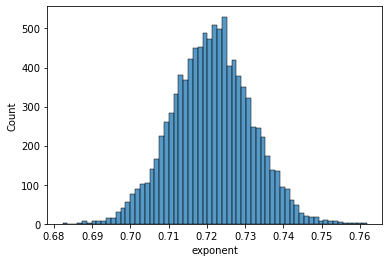

In [8]:
sns.histplot(data=fit_df, x="exponent")
plt.savefig('../figures/pantheria_metabolic_rate_scaling_fit_exponent.png', dpi=600, facecolor='w')


In [9]:
# Fit without even-toed ungulates ('Artiodactyla'), since White & Seymour PNAS '03 claim this is a source of bias.
mask = sub_df['MSW05_Order'] != 'Artiodactyla'
no_artio_df = sub_df[mask]
print(no_artio_df.shape)

# Note power-law fitting code subtly assumes log base e by exponentiating the fit intercept
xs, ys = no_artio_df['5-1_AdultBodyMass_g'], no_artio_df['18-1_BasalMetRate_mLO2hr']
log_xs, log_ys = np.log(xs), np.log(ys)
exp, pre, r = fit_power_law_odr(log_xs, log_ys)
print('y ≈ {0:.2f} x^{1:.2f}, R = {2:.3f}'.format(pre, exp, r))

residuals = (log_ys - (pre + exp*log_xs))
sub_df['residual'] = residuals
sub_df['abs_residual'] = np.abs(residuals)

exponents, prefactors, rs = bootstrap_power_law_odr(xs, ys, rounds=10000)

fit_df = pd.DataFrame(dict(exponent=exponents, prefactor=prefactors, R=rs))

(561, 57)
y ≈ 3.61 x^0.71, R = 0.958


In [10]:
median_fit = fit_df.median()
fit_df.quantile(q=[0.01,0.1,0.25,0.5,0.75,0.9,0.99])

,exponent,prefactor,R
0.01,0.690491,3.192110,0.920346
0.10,0.701408,3.371941,0.940336
0.25,0.707876,3.481835,0.951239
0.50,0.714850,3.611132,0.959351
0.75,0.721707,3.750950,0.969358
0.90,0.727483,3.879520,0.972332
0.99,0.737309,4.117819,0.975613


<AxesSubplot:xlabel='exponent', ylabel='Count'>

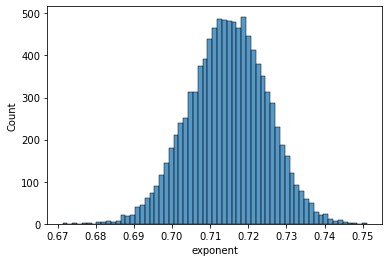

In [11]:
sns.histplot(data=fit_df, x="exponent")